In [72]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [73]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [74]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [75]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [76]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수

In [77]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


# 자격유형

In [78]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

In [79]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
train.shape, test.shape

((2577, 38), (936, 37))

# 1차원

In [80]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()
data.shape

(414, 30)

In [81]:
# train
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.공급유형.unique():
    data[str(i)]=0
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val
data=data.fillna(0)
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
data=pd.merge(data, sample, on="단지코드", how="inner")


# test
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.공급유형.unique():
    dat[str(i)]=0
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val
    
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val
dat=dat.fillna(0)
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
dat=pd.merge(dat, sample, on="단지코드", how="inner")

147


In [82]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',    '상가비율',  '세대당_가능주차면수',
             '공가수비율',        '행복주택',        '영구임대',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             '자격유형4',             '자격유형2',
                   '자격유형7',             '자격유형1',             '자격유형6',             '자격유형3',
                   '자격유형5',      '대형전용면적']
data.columns=[  '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',  '상가비율',
        '세대당_가능주차면수',       '공가수비율',        '국민임대',        '영구임대',
              '임대상가',    '공공임대(단기)',        '장기전세',        '행복주택',
          '공공임대(분납)',        '공공분양',   '공공임대(50년)',         '임대료',
             '임대보증금', '자격유형1',  '자격유형2',             '자격유형7',
                   '자격유형3', '자격유형6','자격유형4','자격유형5',
            '대형전용면적']

In [83]:
data = data.drop([ '자격유형4','자격유형2','자격유형7','자격유형1','자격유형6', '자격유형5'],axis=1)
dat = dat.drop([ '자격유형4','자격유형2','자격유형7','자격유형1','자격유형6', '자격유형5'],axis=1)



# correlation 체크

In [84]:
for (idx1, i) in enumerate(data.corr().columns):
    for (idx2, j) in enumerate(data.corr().columns):
        if (abs(data.corr().iloc[idx1,idx2])>=0.7)&(abs(data.corr().iloc[idx1,idx2])<1.0):
            print(i,"+",j,": ",data.corr().iloc[idx1,idx2])

총세대수 + 단지내주차면수 :  0.7709197113702296
단지내주차면수 + 총세대수 :  0.7709197113702296
단지내주차면수 + 등록차량수 :  0.8512504330670234
등록차량수 + 단지내주차면수 :  0.8512504330670234
세대당_인구 + 남/여_20~39세 :  -0.7004319473100348
세대당_인구 + 0~19세_비율 :  0.8430115273629909
세대당_인구 + 70세이상_비율 :  -0.7490693963078331
남/여비율 + 남/여_40~69세 :  0.8330993369676849
남/여_20~39세 + 세대당_인구 :  -0.7004319473100348
남/여_40~69세 + 남/여비율 :  0.8330993369676849
0~19세_비율 + 세대당_인구 :  0.8430115273629909
0~19세_비율 + 40~69세_비율 :  -0.7557828415973857
0~19세_비율 + 70세이상_비율 :  -0.7931337560335093
20~39세_비율 + 70세이상_비율 :  -0.8031459325572604
40~69세_비율 + 0~19세_비율 :  -0.7557828415973857
70세이상_비율 + 세대당_인구 :  -0.7490693963078331
70세이상_비율 + 0~19세_비율 :  -0.7931337560335093
70세이상_비율 + 20~39세_비율 :  -0.8031459325572604
상가비율 + 영구임대 :  0.8727951968411309
상가비율 + 임대상가 :  0.9166572753424912
상가비율 + 대형전용면적 :  0.8711156905429878
영구임대 + 상가비율 :  0.8727951968411309
영구임대 + 임대상가 :  0.8832683555791294
영구임대 + 대형전용면적 :  0.8716026386731978
임대상가 + 상가비율 :  0.9166572753424912
임대상가 + 영구임대 :  0

## 은영이 전처리 가지고옴

# 나눠서 모델링

In [85]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [86]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 43) (104, 43)
(113, 40) (34, 40)


In [94]:
train1

,단지코드,총세대수,지역,공가수,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,연면적,위도,경도,subway_name,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,...,0~19세_비율,20~39세_비율,40~69세_비율,70세이상_비율,상가비율,세대당_가능주차면수,공가수비율,국민임대,영구임대,임대상가,공공임대(단기),장기전세,행복주택,공공임대(분납),공공분양,공공임대(50년),임대료,임대보증금,자격유형3,대형전용면적
0,C2515,545,경상남도,17.0000,0.0000,3.0000,624.0000,205.0000,미수휴먼시아,경상남도 통영시 미우지해안로 107,"1,213.8700",128.3965,34.8242,다대포해수욕장역,0.6117,1,"11,129.0000",2.3000,0.9700,1.7612,...,0.1956,0.1850,0.5221,0.0972,0.0000,1.1450,0.0312,545,0,0,0,0,0,0,0,0,"139,557.1429","16,787,142.8571",0.0000,0
2,C1945,755,경기도,6.0000,1.0000,3.0000,734.0000,730.0000,호평마을 주공휴먼시아,경기도 남양주시 늘을3로 8,"6,017.7600",127.2408,37.6584,평내호평역,0.0063,1,"57,499.0000",2.6500,0.9500,1.9906,...,0.2349,0.2390,0.4468,0.0793,0.0000,0.9722,0.0079,635,0,0,0,0,0,0,0,0,"200,914.0000","24,060,600.0000",635.0000,0
3,C1470,696,전라북도,14.0000,0.0000,2.0000,645.0000,553.0000,장신휴먼시아1단지,전라북도 익산시 오산면 선화로4길 66,"6,611.9000",126.9312,35.9467,연산역,0.3785,2,"7,783.0000",2.0000,0.9800,1.8224,...,0.1429,0.1798,0.4903,0.1871,0.0000,0.9267,0.0201,696,0,0,0,0,0,0,0,0,"120,150.0000","17,722,750.0000",0.0000,0
4,C1898,566,전라북도,9.0000,0.0000,6.0000,517.0000,415.0000,장신휴먼시아2단지,전라북도 익산시 오산면 선화로4길 24-9,"6,749.2000",126.9320,35.9486,연산역,0.3766,2,"7,783.0000",2.0000,0.9800,1.8224,...,0.1429,0.1798,0.4903,0.1871,0.0000,0.9134,0.0159,566,0,0,0,0,0,0,0,0,"119,148.3333","17,422,333.3333",0.0000,0
6,C1171,624,대전광역시,13.0000,0.0000,5.0000,634.0000,700.0000,LH대전노은3지구4단지,대전광역시 유성구 지족로148번길 40,"4,595.1900",127.3050,36.3772,노은역,0.0132,1,"28,168.0000",2.6000,0.9733,1.9404,...,0.2417,0.2619,0.4351,0.0613,0.0000,1.0160,0.0208,604,0,0,0,0,0,0,0,0,"174,081.8182","31,163,363.6364",0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,C2586,90,제주특별자치도,7.0000,0.0000,3.0000,66.0000,57.0000,서귀포서홍행복주택,제주특별자치도 서귀포시 장수로 115,67.9800,126.5554,33.2557,평동역,1.8812,1,"7,195.5000",2.1050,1.0000,1.8219,...,0.2102,0.2183,0.4603,0.1112,0.0000,0.7333,0.0778,0,0,0,0,0,90,0,0,0,"111,180.0000","26,160,000.0000",0.0000,0
410,C2035,492,강원도,24.0000,0.0000,1.0000,521.0000,246.0000,춘천우두 국민임대 3단지,강원도 춘천시 우두1길 40,59.4100,127.7372,37.9097,춘천역,0.0324,1,"23,027.0000",2.4100,1.0100,2.2876,...,0.1979,0.2587,0.4337,0.1096,0.0000,1.0589,0.0488,492,0,0,0,0,0,0,0,0,"158,800.0000","15,730,000.0000",0.0000,0
411,C2020,40,부산광역시,7.0000,1.0000,2.0000,25.0000,19.0000,부산용호(행복주택),부산광역시 남구 동명로 183,152.2900,129.1169,35.1187,남천역,0.0250,1,"20,603.2500",2.3900,0.9450,1.7453,...,0.1699,0.2025,0.4957,0.1318,0.0000,0.6250,0.1750,0,0,0,0,0,40,0,0,0,"135,976.6667","28,133,333.3333",0.0000,0
412,C2437,90,충청북도,12.0000,0.0000,1.0000,30.0000,16.0000,제천청전(공공실버),충청북도 제천시 용두천로40길 28,88.8600,128.2186,37.1561,여주역,0.6035,1,"9,989.0000",2.3000,0.9700,1.8302,...,0.1887,0.2314,0.4785,0.1014,0.0000,0.3333,0.1333,0,90,0,0,0,0,0,0,0,"107,530.0000","10,346,000.0000",0.0000,0


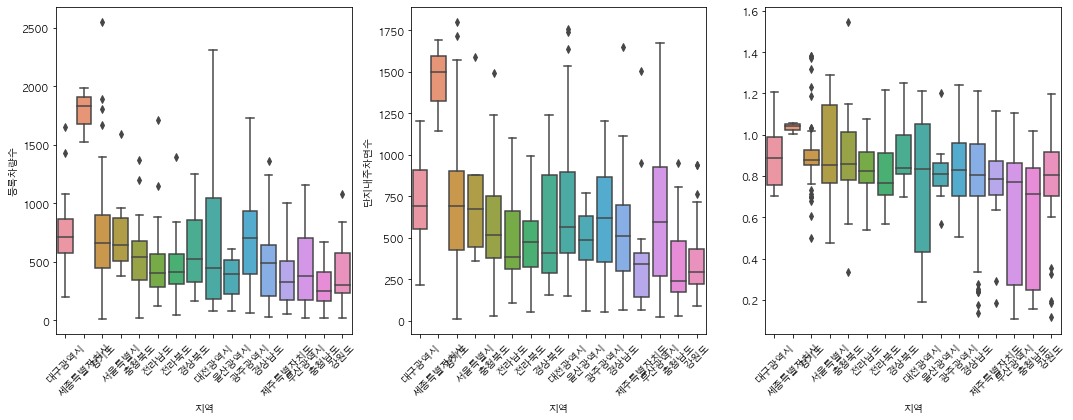

In [108]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot( data.지역,data.등록차량수,order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.subplot(1,3,2)
sns.boxplot(data.지역,data.단지내주차면수,order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.subplot(1,3,3)
sns.boxplot(data.지역,data["단지내주차면수"]/data["총세대수"],order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.show()

In [109]:
data["지역1"] = data["지역"]

In [110]:
data.loc[data.지역.isin(["충청남도","충청북도"]),"지역1"] = "충청도"
data.loc[data.지역.isin(["전라남도","전라북도"]),"지역1"] = "전라도"
data.loc[data.지역.isin(["경상남도","경상북도"]),"지역1"] = "경상도"

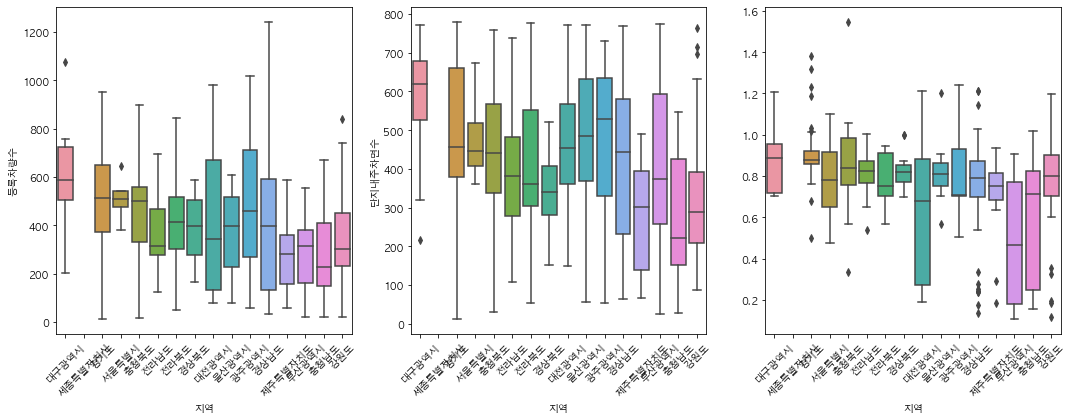

In [106]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot( train1.지역,train1.등록차량수,order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.subplot(1,3,2)
sns.boxplot(train1.지역,train1.단지내주차면수,order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.subplot(1,3,3)
sns.boxplot(train1.지역,train1["단지내주차면수"]/train1["총세대수"],order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.show()

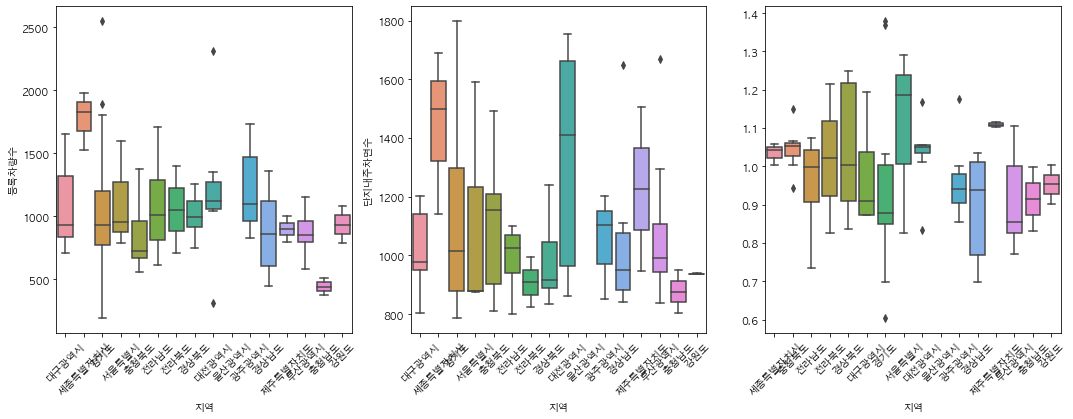

In [116]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot( train2.지역,train2.등록차량수,order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.subplot(1,3,2)
sns.boxplot(train2.지역,train2.단지내주차면수,order = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.subplot(1,3,3)
sns.boxplot(train2.지역,train2["단지내주차면수"]/train2["총세대수"],order = ['세종특별자치시','충청북도','전라남도','전라북도','경상북도','대구광역시','경기도','서울특별시','대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도'])
plt.xticks(rotation=45)
plt.show()

# CV

In [55]:
# Fitting
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# import lightgbm as LGB
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error 

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold

In [56]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
        best_tst_pred = sum(best_tst_pred,[])
        best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [87]:
models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          #SVR(),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021)
#           XGBRegressor(random_state=2021)
         ]


In [89]:
X1 = train1.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가"])
X1 = pd.get_dummies(X1, drop_first=True)
y1=train1["등록차량수"]
best_model1, best_tst_pred1, best_error1 = fit_models(X1, y1, models)
best_model1, best_error1

(Ridge(random_state=2021), 99.3750585782736)

In [93]:
for (idx1, i) in enumerate(X1.corr().columns):
    for (idx2, j) in enumerate(X1.corr().columns):
        if (abs(X1.corr().iloc[idx1,idx2])>=0.7)&(abs(X1.corr().iloc[idx1,idx2])<1.0):
            print(i,"+",j,": ",X1.corr().iloc[idx1,idx2])

총세대수 + 영구임대 :  0.7304124630897985
subway_dist + 지역_제주특별자치도 :  0.772360905296389
세대당_인구 + 0~19세_비율 :  0.8456879526698393
세대당_인구 + 70세이상_비율 :  -0.7416101051695724
남/여비율 + 남/여_40~69세 :  0.825480902562422
남/여_40~69세 + 남/여비율 :  0.825480902562422
0~19세_비율 + 세대당_인구 :  0.8456879526698393
0~19세_비율 + 40~69세_비율 :  -0.7021664100190148
0~19세_비율 + 70세이상_비율 :  -0.7753383259314408
20~39세_비율 + 70세이상_비율 :  -0.8087717367904668
40~69세_비율 + 0~19세_비율 :  -0.7021664100190148
70세이상_비율 + 세대당_인구 :  -0.7416101051695724
70세이상_비율 + 0~19세_비율 :  -0.7753383259314408
70세이상_비율 + 20~39세_비율 :  -0.8087717367904668
상가비율 + 세대당_가능주차면수 :  -0.7281156559228308
상가비율 + 영구임대 :  0.8816598348985227
상가비율 + 대형전용면적 :  0.8684488806462849
세대당_가능주차면수 + 상가비율 :  -0.7281156559228308
영구임대 + 총세대수 :  0.7304124630897985
영구임대 + 상가비율 :  0.8816598348985227
영구임대 + 대형전용면적 :  0.8801645468280693
대형전용면적 + 상가비율 :  0.8684488806462849
대형전용면적 + 영구임대 :  0.8801645468280693
지역_제주특별자치도 + subway_dist :  0.772360905296389


In [92]:
X2=train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가"])
X2 = pd.get_dummies(X2, drop_first=True)
y2=train2["등록차량수"]
best_model2, best_tst_pred2, best_error2 = fit_models(X2, y2, models)
best_model2, best_error2 

(ElasticNet(random_state=2021), 246.3976102611218)